In [107]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, HMCForecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat, periodic_cumsum
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage
import skimage.morphology as morph
from scipy import ndimage

%matplotlib inline
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(20200305)

### Synthetic test data

torch.Size([10000, 4])
torch.float32


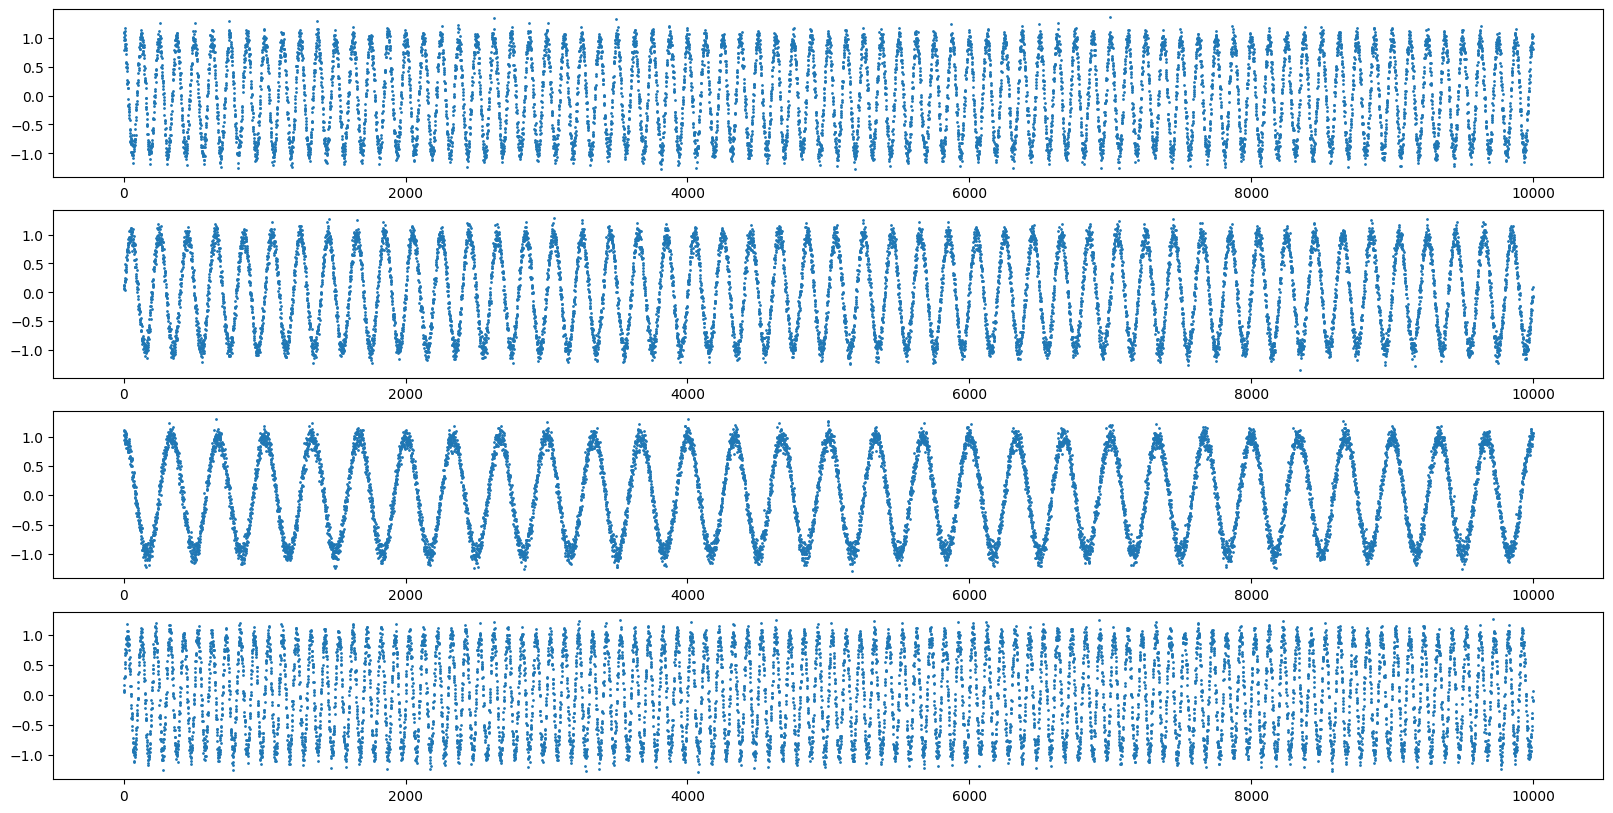

In [221]:
time=torch.linspace(0,2*math.pi*(100),100*100).unsqueeze(-1)
time2D = time.tile((4,))*torch.tensor([0.8,0.5,0.3,1])+torch.tensor([math.pi/2,0,math.pi/2,0])
data2D_clean=torch.sin(time2D)
data2D=data2D_clean+torch.randn(data2D_clean.shape)*0.1
print(data2D.shape)
print(data2D.dtype)

T0 = 0
T2 = data2D.size(-2)
T1 = T2-1000 # predict last two cycles

fig,ax=plt.subplots(4,1,figsize=(20,10))
ax[0].scatter(torch.arange(T0,T2),data2D[:,0],s=1)
ax[1].scatter(torch.arange(T0,T2),data2D[:,1],s=1)
ax[2].scatter(torch.arange(T0,T2),data2D[:,2],s=1)
ax[3].scatter(torch.arange(T0,T2),data2D[:,3],s=1)

### Video data

In [9]:
# Time resolution for the different videos: 
timeResolution = np.array([25, 16, 17, 15, 15, 17, 14])
minTimeResolution = min(timeResolution)
#n_frames = np.array([14516, 4372, 4625, 4078, 3983, 4943, 4593])

# Method to retreive the temporal downsambled videos 
def downsampleTimeResolution(timeResolution,minTimeResolution,n_frames,flag):
    indices = np.round(np.linspace(0,timeResolution-1,minTimeResolution)).astype(int)
    downsample = np.zeros([timeResolution])
    downsample[indices] = 1
    if flag==1:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution))) # returns boolean array
        print(downsampleFrames.shape)
        return downsampleFrames
    
    else:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution)))
        downsampleFramesIdx = np.where(downsampleFrames==1) # return indices of frames to sample in video
        print(downsampleFramesIdx[0].shape)
        return downsampleFramesIdx

In [10]:
videosList=[]
max_frames = 100000

# Load and save all videos to numpy object
for vidIdx in range(2):
    vidCv2 = cv2.VideoCapture(f'data/usliverseq-mp4/volunteer{str(vidIdx+1).zfill(2)}.mp4')
    n_frames = int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT))
    sampleFrames = downsampleTimeResolution(timeResolution[vidIdx],minTimeResolution,n_frames,1)
    print(sampleFrames.shape)
    frameIdx = 0
    frames = []
    while(vidCv2.isOpened() and frameIdx<sampleFrames.shape[0]) and frameIdx<max_frames:
        ret, frame = vidCv2.read()
        if ret == True and sampleFrames[frameIdx]:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        if ret == False:
            break
        frameIdx+=1

    #number of frames in video:
    print(f'volunteer{str(vidIdx+1).zfill(2)}.mp4:\n')
    print("number of frames:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT)))

    #frame size:
    print("frame size:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_WIDTH)), "x", int(vidCv2.get(cv2.CAP_PROP_FRAME_HEIGHT)),'\n')

    
    video = np.stack(frames, axis=0)
    videosList.append(video)

    cv2.destroyAllWindows()

(14500,)
(14500,)
volunteer01.mp4:

number of frames: 14516
frame size: 640 x 480 

(4368,)
(4368,)


KeyboardInterrupt: 

In [ ]:
# Load the points used for affine tranformation -- Found with commented code above 
ptsArray = np.load('transPts.npz')["arr_0"]
print(ptsArray.shape)

(7, 4, 2)


In [ ]:
# Transfor all videos have the same field of view as the agreed upon reference video
# We agree on a reference video which all other videos are transformed to, video 2, i.e. video index 1
refIdx=1
_ , refRows, refCols = videosList[refIdx].shape
refPts = ptsArray[refIdx]

videosTransList = []

for videoIdx,video in enumerate(videosList):
    if videoIdx!=refIdx:
        transPts = ptsArray[videoIdx]
        M = cv2.getPerspectiveTransform(transPts, refPts)
        
        framesTransList = []
        for frameIdx,frame in enumerate(video):
            frameTrans = cv2.warpPerspective(frame, M, (refCols, refRows))
            framesTransList.append(frameTrans)

        videosTransList.append(np.array(framesTransList))
    else: 
        # Append reference frame video without affine transformation
        videosTransList.append(video)

In [ ]:
# Creating mask for field of view and removing background
disk = np.zeros((40,40))
element = skimage.draw.disk((20,20),9,shape=(40,40))

# Pick sigma for gaussian filter: 
sigma_for_gaussian_filter = (0,3,3)

disk[element]=1
morphsInput = []
videoMasks = []
videosTransMaskList = []

for vidIdx,vid in enumerate(videosTransList):
    vidThr = np.zeros(vid.shape[1:])
    for frameIdx,frame in enumerate(vid):
        vidThr+=frame>10
    morphInput=vidThr>0
    vidMask = morph.opening(morphInput,disk) # First opening
    vidMask = morph.closing(vidMask,disk) # Then closing
    morphsInput.append(morphInput)
    videoMasks.append(vidMask)
    tmp_blurred = ndimage.gaussian_filter(vid,sigma=sigma_for_gaussian_filter)
    videosTransMaskList.append(tmp_blurred*vidMask[None,:,:])

Text(0.5, 1.0, 'Final processed video')

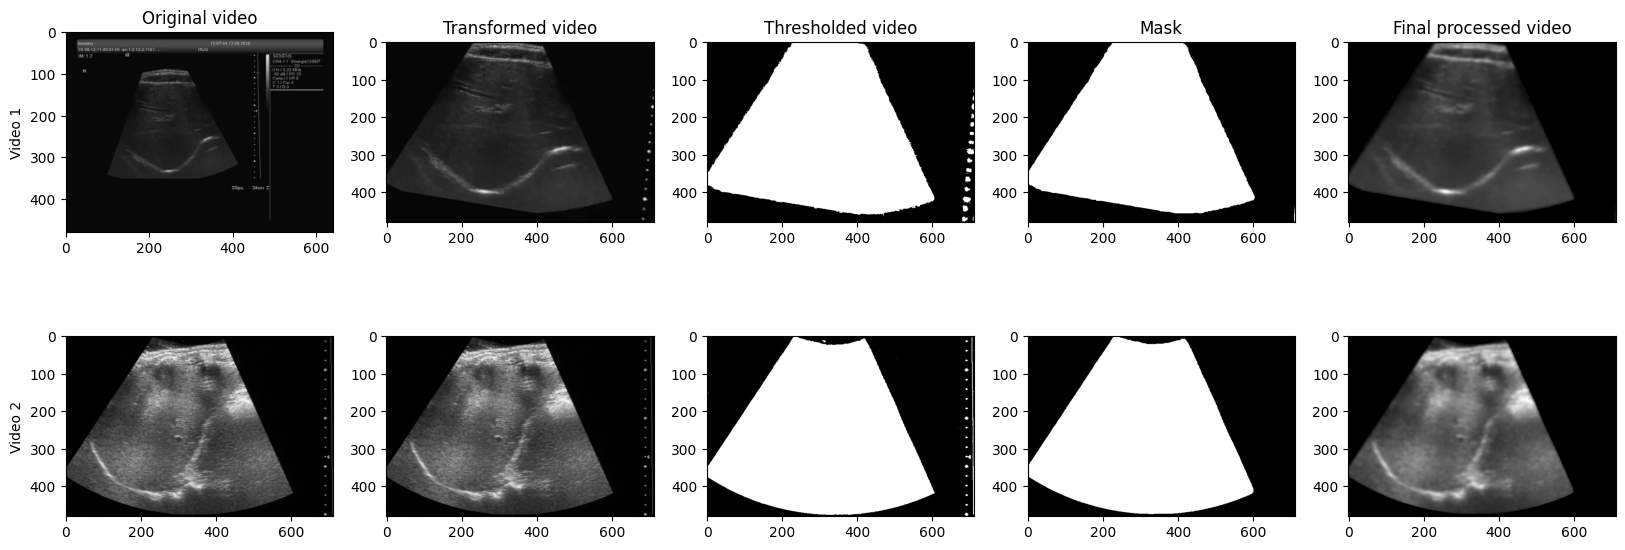

In [ ]:
# Visualisation of final frames of final videos: 
frameIdx=0 # Choose which frame should be visualized

fig,ax = plt.subplots(len(videosList),5,figsize=(20,7))
for vidIdx in range(len(videosList)):
        ax[vidIdx,0].imshow(videosList[vidIdx][frameIdx],cmap='gray')
        ax[vidIdx,1].imshow(videosTransList[vidIdx][frameIdx],cmap='gray')
        ax[vidIdx,2].imshow(morphsInput[vidIdx],cmap='gray')
        ax[vidIdx,3].imshow(videoMasks[vidIdx],cmap='gray')
        ax[vidIdx,4].imshow(videosTransMaskList[vidIdx][frameIdx],cmap='gray')
        ax[vidIdx,0].set_ylabel(f'Video {vidIdx+1}')
ax[0,0].set_title('Original video')
ax[0,1].set_title('Transformed video')
ax[0,2].set_title('Thresholded video')
ax[0,3].set_title('Mask')
ax[0,4].set_title('Final processed video')

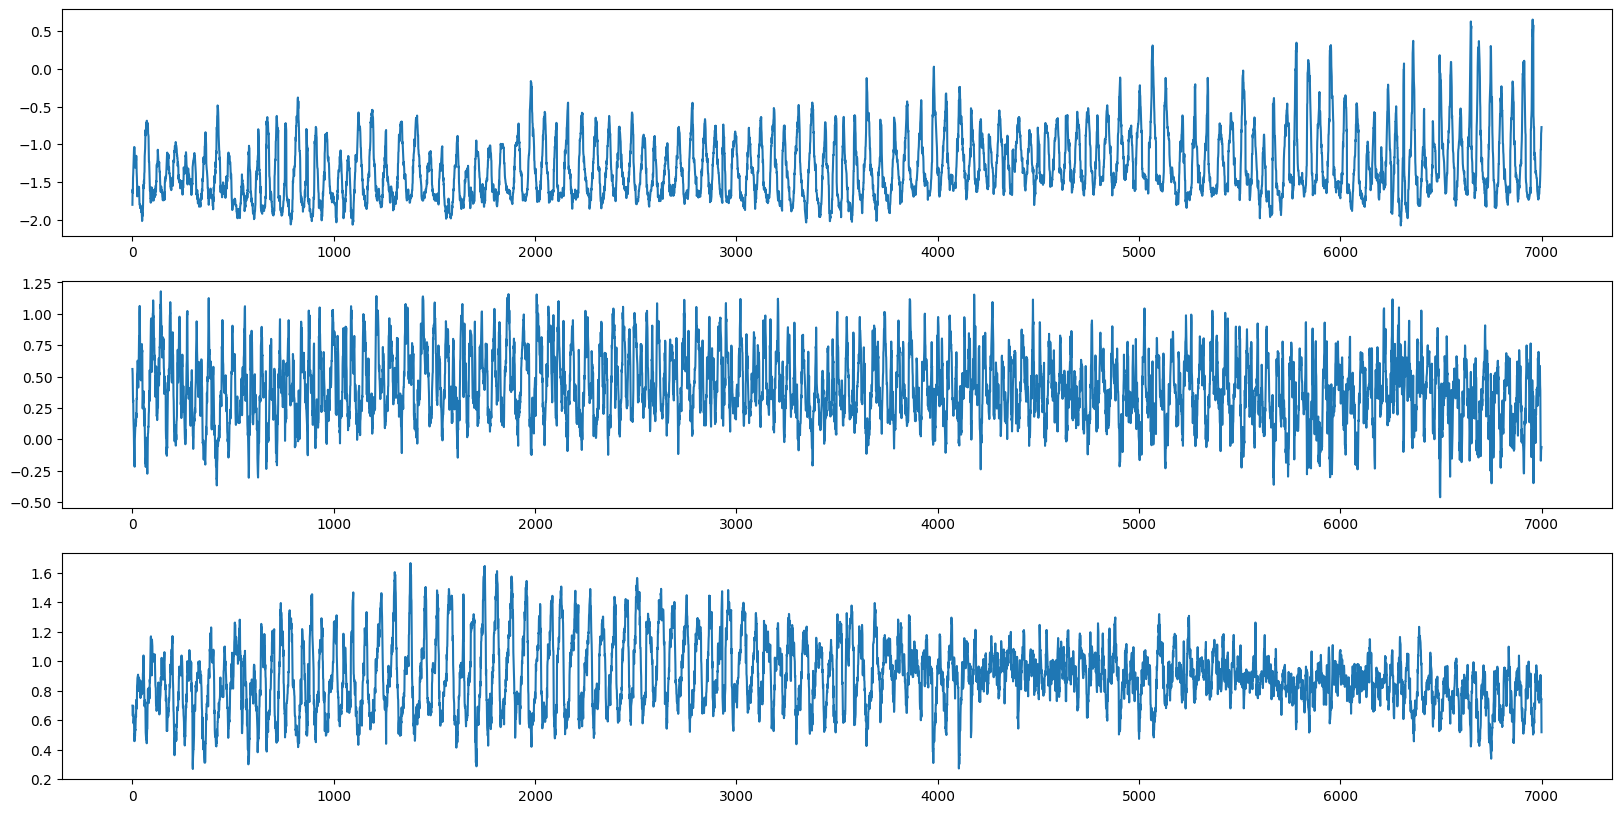

In [176]:
timePts=videosTransMaskList[0].shape[0]
pixelMeans=[]
for i in range(5,8):
    start=i*50
    stop=i*50+50
    pixelMeans.append(videosTransMaskList[0][:7000,start:stop,100+start:100+stop].mean(axis=(1,2)))

pixelMeans=np.array(pixelMeans)
pixelMeans=(pixelMeans-pixelMeans.mean())/pixelMeans.std()

fig,ax=plt.subplots(3,1,figsize=(20,10))
for i in range(3):
    ax[i].plot(range(timePts)[:7000],pixelMeans[i])

In [92]:
type(pixelMeans[0,0])

numpy.float64

In [177]:
data2D=torch.from_numpy(pixelMeans.T).float()
print(data2D.shape)
print(data2D.dtype)
T0=0
T2 = data2D.size(-2)
T1 = T2-400 # predict last two cycles

torch.Size([7000, 3])
torch.float32


### GaussianHMM

In [232]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        period=1000
        hidden_dim=2
        duration, obs_dim = zero_data.shape[-2:]

        # Sample global parameters.
        # noise_scale = pyro.sample(
        #     "noise_scale", dist.LogNormal(torch.full((dim,), -3.0), 1.0).to_event(1)
        # )
        # assert noise_scale.shape[-1:] == (dim,)

        # Note the initial seasonality should be sampled in a plate with the
        # same dim as the time_plate, dim=-1. That way we can repeat the dim
        # below using periodic_repeat().
        with pyro.plate("season_plate", period, dim=-1):
            season_init = pyro.sample(
                "season_init", dist.Normal(torch.zeros(obs_dim), 1).to_event(1)
            )
        assert season_init.shape[-2:] == (period, obs_dim)

        # Sample independent noise at each time step.
        # with self.time_plate:
        #     season_noise = pyro.sample(
        #         "season_noise", dist.Normal(0, noise_scale).to_event(1)
        #     )
        #     assert season_noise.shape[-2:] == (duration, dim)

        # Construct a prediction. This prediction has an exactly repeated
        # seasonal part plus slow seasonal drift. We use two deterministic,
        # linear functions to transform our diagonal Normal noise to nontrivial
        # samples from a Gaussian process.
        prediction = periodic_repeat(season_init, duration, dim=-2) #+ periodic_cumsum(
        #   season_noise, period, dim=-2
        #)
        assert prediction.shape[-2:] == (duration, obs_dim)

        # We'll hard-code the periodic part of this model, learning only the local model.
        #prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)
        #prediction = periodic_repeat(means, duration, dim=-2)

        # On top of this mean prediction, we'll learn a linear dynamical system.
        # This requires specifying five pieces of data, on which we will put structured priors.
    

        trans_timescale = pyro.sample(
            "trans_timescale", dist.LogNormal(torch.zeros(hidden_dim), 1).to_event(1)
        )
        assert trans_timescale.shape[-1:] == (hidden_dim,)

        trans_loc = pyro.sample("trans_loc", dist.Cauchy(0, 1 / period))
        trans_loc = trans_loc.unsqueeze(-1).expand(trans_loc.shape + (hidden_dim,))
        assert trans_loc.shape[-1:] == (hidden_dim,)
        trans_scale = pyro.sample(
            "trans_scale", dist.LogNormal(torch.zeros(hidden_dim), 0.1).to_event(1)
        )
        trans_corr = pyro.sample("trans_corr", dist.LKJCholesky(hidden_dim, torch.ones(())))
        trans_scale_tril = trans_scale.unsqueeze(-1) * trans_corr
        assert trans_scale_tril.shape[-2:] == (hidden_dim, hidden_dim)

        obs_scale = pyro.sample(
            "obs_scale", dist.LogNormal(torch.zeros(obs_dim), 0.1).to_event(1)
        )
        obs_corr = pyro.sample("obs_corr", dist.LKJCholesky(obs_dim, torch.ones(())))
        obs_scale_tril = obs_scale.unsqueeze(-1) * obs_corr
        assert obs_scale_tril.shape[-2:] == (obs_dim, obs_dim)


        init_dist = dist.Normal(torch.zeros(hidden_dim), 10).to_event(1)
        trans_mat = trans_timescale.neg().exp().diag_embed()
        trans_dist = dist.MultivariateNormal(trans_loc, scale_tril=trans_scale_tril)
        obs_mat = torch.randn(hidden_dim,obs_dim)
        obs_dist = dist.MultivariateNormal(torch.zeros(obs_dim), scale_tril=obs_scale_tril)
        noise_model = dist.GaussianHMM(
            init_dist, trans_mat, trans_dist, obs_mat, obs_dist, duration=duration
        )
        assert noise_model.event_shape == (duration, obs_dim)

        noise_dist = dist.GaussianHMM(
            init_dist, trans_mat, trans_dist, obs_mat, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [233]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data2D), 0)  # empty
forecaster = Forecaster(Model1(), data2D[:T1], covariates[:T1], learning_rate=0.1, num_steps=400,clip_norm=1)
#forecaster = HMCForecaster(Model1(), data2D[:T1], covariates[:T1])

for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 2.97367
INFO 	 step  100 loss = 0.0290829
INFO 	 step  200 loss = -0.322816
INFO 	 step  300 loss = -0.392928


trans_loc = 0.002722
CPU times: total: 1min 51s
Wall time: 28.5 s


torch.Size([500, 1000, 4]) torch.Size([1000, 4]) torch.Size([1000, 4])


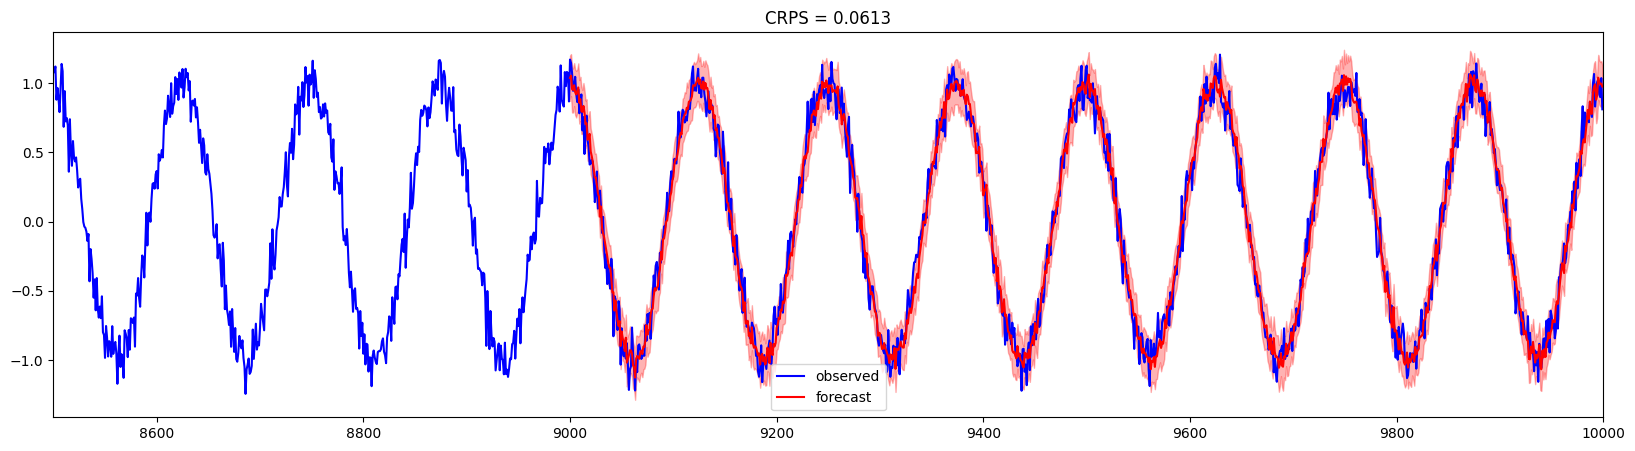

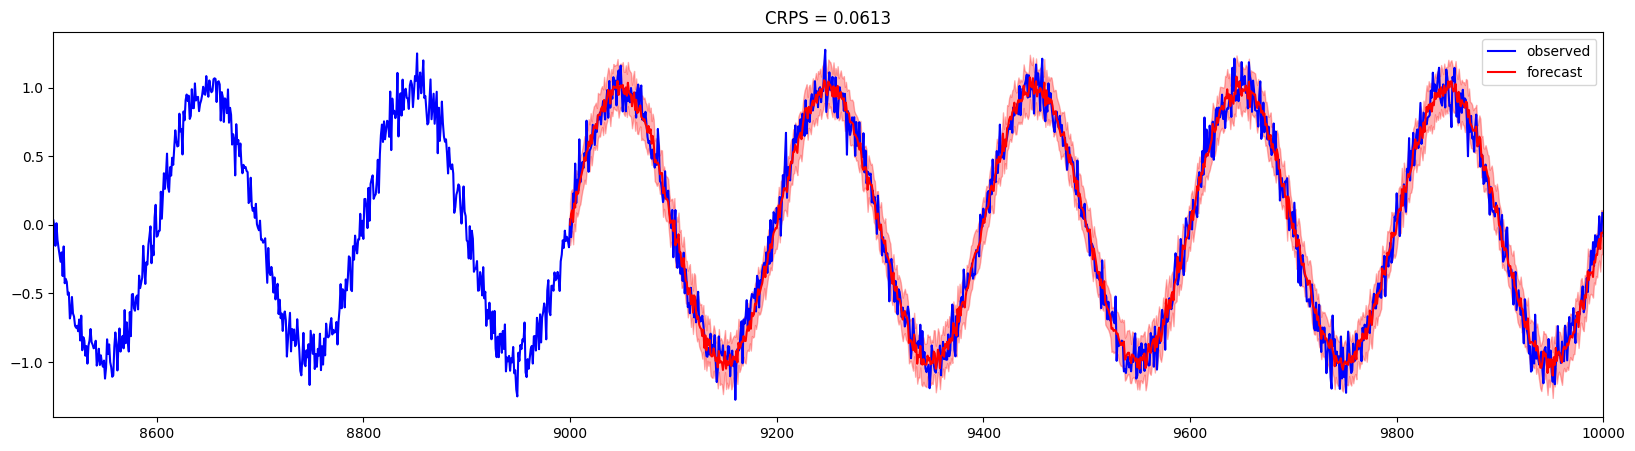

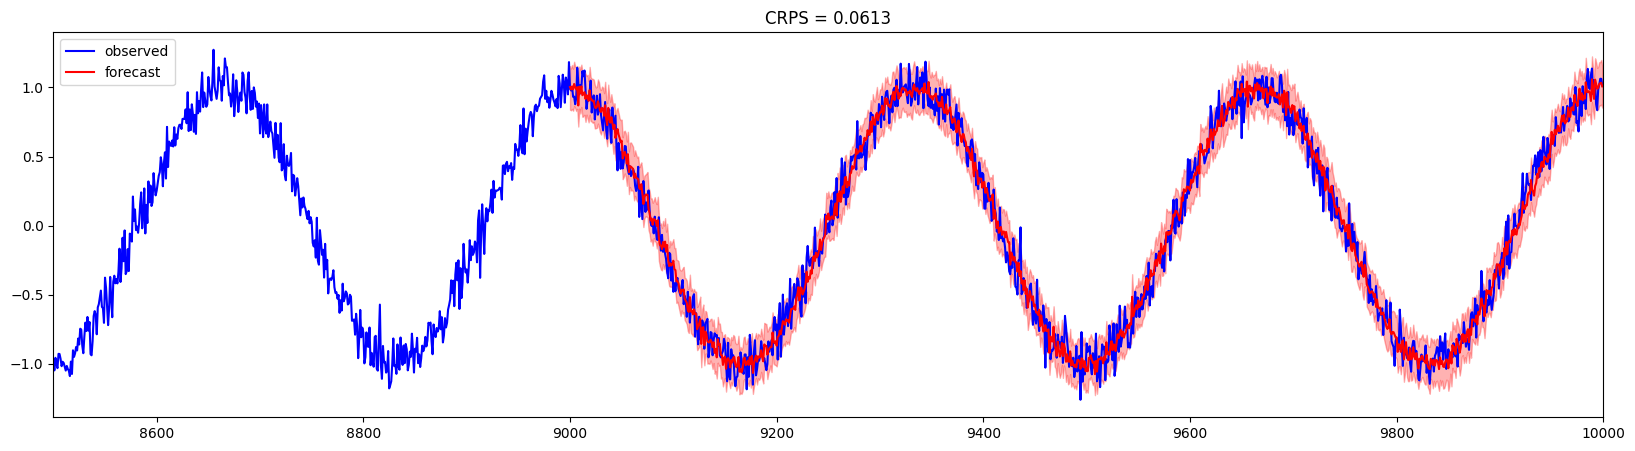

In [234]:
samples = forecaster(data2D[:T1], covariates, num_samples=500)
#samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
meanSamples=samples.mean(dim=0)
crps = eval_crps(samples, data2D[T1:])
print(samples.shape, p10.shape,meanSamples.shape)


for printIdx in range(3):
    plt.figure(figsize=(20, 5))
    plt.fill_between(torch.arange(T1, T2), p10[:,printIdx], p90[:,printIdx], color="red", alpha=0.3)
    #plt.scatter(torch.arange(T1, T2), p50[:,printIdx], s=1,c='r', label='forecast')
    plt.plot(torch.arange(T1-500, T2), data2D[T1-500 : T2,printIdx], '-b', label='observed')
    plt.plot(torch.arange(T1, T2), meanSamples[:,printIdx], '-r', label='forecast')
    #plt.plot(torch.arange(T1-(500), T2),data2D_clean[T1-(500) : T2,printIdx], 'k-', label='truth')
    plt.title("CRPS = {:0.3g}".format(crps))
    plt.xlim(T1-(500), T2)
    plt.legend(loc="best");

# plt.figure(figsize=(9, 3))
# plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
# plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
# plt.plot(torch.arange(T1 - 24 * 7, T2),
#          data[T1 - 24 * 7: T2], 'k-', label='truth')
# plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
# plt.ylabel("log(# rides)")
# plt.xlabel("Hour after 2011-01-01")
# plt.xlim(T1 - 24 * 7, T2)
# plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
# plt.legend(loc="best");